In [ ]:
import torch
from pathlib import Path
import pandas as pd
import io
import matplotlib.pyplot as plt
import numpy as np

# **CIFAR-10 Logistic Regression Predictor**
This code repository trains on the CIFAR-10 code repository (http://www.cs.toronto.edu/~kriz/cifar.html), using a logistic regression model in PyTorch.

CIFAR-10 is one of Pytorch's test datasets, so we can easily access it directly from PyTorch.

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True)
# labels
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


100%|██████████| 170498071/170498071 [00:08<00:00, 20367487.08it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


We can check the lengths of our training set and our test set.

In [ ]:
print('length of training set: ' + str(len(trainset)))
print('length of test set: ' + str(len(testset)))

length of training set: 50000
length of test set: 10000


We can then analyze a specific image from the dataset - they are all of size 32 x 32 pixels, and this one has Y label 6 - it's a picture of a frog.

In [ ]:
trainset[0]

(<PIL.Image.Image image mode=RGB size=32x32>, 6)

It's of class PIL, which is from pillow, a python image processing library. We can use matplotlib to see what this actual image looks like. Use the magic command matplotlib.inline to show images within browser (not a popup)

In [ ]:
# set matplotlib to inline, which makes sure it doesn't create a popup and displays it in terminal.
# INLINE IS NOT NEEDED IN COLAB !

Now, we can look at each image. Change the value of example to get a different picture in the training set.

this is an image of a frog


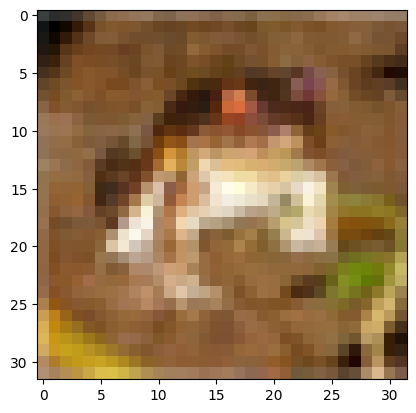

In [ ]:
example = 0
image, label = trainset[example] #since each element of the trainset list is itself a tuple with the image details, and then the label
print("this is an image of a " + classes[(trainset[example])[1]]) # first index into tuple in trainset, then the 2nd value (label), and then the classes
plt.imshow(image)


## Transforming images into matrices of color values


---


Now we need to use the PyTorch transforms module to transform the images into matrices of color values, which we can then transform into tensors, for each pixel. Import transform module for that very purpose.

In [ ]:
import torchvision.transforms as transforms

Now, we can reintroduce our training dataset, but a transformed version, where each example is now a set of three matrices (one for each R, G, B color channel), each of the being 32 x 32, with each component being the color value of that channel for that pixel in that image. Regularly, we would just import it like this in the first place, but we did the other thing in order to look at the images beforehand.


In [ ]:
datasetT = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transforms.ToTensor())

Files already downloaded and verified


Now that we have transformed our image (formerly something like <PIL.Image.Image image mode=RGB size=32x32 at 0x7F1FD056CEF0>), we can fish into our transformed dataset to retrieve our matrix for a certain image, as well as the label. Change x for the example from training set. We can see that each picture is a vector of 3x32x32, which is the three color channels, each color channel containing 32x32 pixels.

In [ ]:
example = 5
imgTensor, label = datasetT[example]
print('size of image matrix: ' + str(imgTensor.shape))
print("this is an image of a " + classes[(trainset[example])[1]])

size of image matrix: torch.Size([3, 32, 32])
this is an image of a car


Let's take a look at the pixel values for R, G, and B, for a small section of the image - let's say four pixels that form a square in the bottom left hand of our image.

In [ ]:
print(imgTensor[:, 0:2, 0:2])

tensor([[[0.6235, 0.5882],
         [0.5569, 0.5725]],

        [[0.4000, 0.3569],
         [0.2941, 0.2824]],

        [[0.3961, 0.3725],
         [0.2667, 0.2588]]])


We can also actually plot the image directly from the imgTensor values:

R channel of image 0 in dataset


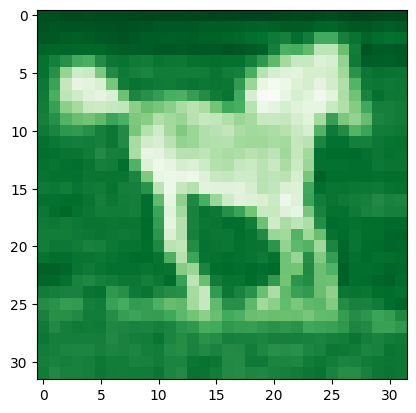

In [ ]:
example = 21344
imgTensor, label = datasetT[example]
plt.imshow(imgTensor[1, 0:32, 0:32], cmap='Greens')
# change the 0 to 1 or 2 for different color channels.
print("R channel of image 0 in dataset")

## Splitting up dataset into Training and Validation sets


---
Since there is no predefined validation set, we have to manually split the data up. Even though there are preset functions, let's define our own function from scratch to pick some random indexes from the 50,000 test set images for the validation set.


While building real world machine learning models, it is quite common to split the dataset into 3 parts:
1. the **training set** is used to train the parameters of a given model, and usually takes up around 60% of a total dataset.

2. the **cross-validation set** is used to evaluate the model during training (e.g, to see if gradient descent is working properly), to diagnose over and underfitting, and to adjust hyperparameters like the learning rate. It usually takes up around 20% of the total dataset.

3. the **test set** is used to report the accuracy of the completed model. It usually takes up around 20% of the total dataset.

Now, let's give the length of our total training set as well as how large of a percentage do you want to dedicate to cross validation.


In [ ]:
#length of training examples.
m = 50000

#percentage of m dedicated to CV.
pCV = 0.2

# give the amount of examples dedicated to CV.
mCV = int(m*pCV)
print("amount of training examples: " + str(m - mCV))
print("amount of cross validation examples: " + str(mCV))


amount of training examples: 40000
amount of cross validation examples: 10000


Now, define a function to randomly shuffle data and then slice it into the percentages that we wanted.

In [ ]:
def splitIndices(m, pCV):
  """ randomly shuffle a training set's indices, then split the indices into training and cross validation sets.
   Pass in 'm', length of training set, and 'pCV', the percentage of the training set you would like
   to dedicate to cross validation."""

  # determine size of CV set.
  mCV = int(m*pCV)

  #create random permutation of 0 to m-1 - randomly shuffle all values from 0 to m.
  indices = np.random.permutation(m)

  #pick first mCV indices for training, and then validation.
  return indices[mCV:], indices[:mCV]


Now that we've defined a function, we can put in our desired percentage dedicated to CV, and length of training, to get a list of indices.

In [ ]:
trainIndices, valIndices = splitIndices(m, pCV)

Now print the lengths of the training and val sets as sanity check, as well as print the first few indices of the val set.

In [ ]:
# print the first few indices of the training set, and first few of the validation set, as a sanity check to see that they are shuffled.
print("length of training set: " + str(len(trainIndices)))
print("length of cross validation set: " + str(len(valIndices)))
print()
print('sample validation indices: ' + str(list(valIndices[0:8])))
print('sample educational indices: ' + str(list(trainIndices[0:8])))

length of training set: 40000
length of cross validation set: 10000

sample validation indices: [31911, 43359, 47941, 4714, 43433, 34779, 40861, 20387]
sample educational indices: [1078, 43338, 42174, 10110, 25184, 14030, 2289, 26316]


**The below code does the same as the above.**

In [ ]:
# PRESET CODE -- OPTIMIZED PYTORCH IMPLEMENTATION
#from torch.utils.data import random_split

#train_ds, val_ds = random_split(dataset, [50000, 10000])
#len(train_ds), len(val_ds)

Next, we load the indices into groups for later stochastic gradient descent, as well as ease of programming, since these are quite large matrices.

In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

What this below does is create a sampler object with SubsetRandomSampler, which creates an endlessly iterable 'list' of shuffled indices from trainIndices (just a list of arbitrary numbers).

Then, in trainLoader, say if batch size = 2, 2 images (color value matrices) will be processed from datasetT using the first two indices in trainSampler. This means that there will be two sets of three 32x32 matrices, which reflects the nature that the entire dimensions of the X is technically 50000x3x32x32 (or if our batch size is say 100, 100x3x32x32 for each batch)

In [ ]:
batchSize = 100

# TRAIN SET

# training sampler and data loader - creates a SubsetRandomSampler object that takes random samples of the numbers in trainIndices, or random indices.
trainSampler = SubsetRandomSampler(trainIndices)


# training loader - creates a dataloader object which takes the indices from trainSampler,
# and when given batchSize, takes random batches of batchSize from the indices list, and then pairs it with
# the respective dataset in datasetT
trainLoader = DataLoader(datasetT, batchSize, sampler=trainSampler)

print(list(trainLoader))

# VALIDATION SET

valSampler = SubsetRandomSampler(valIndices)
valLoader = DataLoader(datasetT, batchSize, sampler=valSampler)

[[tensor([[[[0.3647, 0.3490, 0.3216,  ..., 0.3255, 0.3176, 0.2706],
          [0.3216, 0.3176, 0.2784,  ..., 0.2980, 0.2510, 0.1647],
          [0.2824, 0.2745, 0.1765,  ..., 0.2510, 0.1333, 0.0588],
          ...,
          [0.2667, 0.2627, 0.2667,  ..., 0.2275, 0.2000, 0.1725],
          [0.2745, 0.2784, 0.2863,  ..., 0.2275, 0.2078, 0.1765],
          [0.2706, 0.2784, 0.3020,  ..., 0.2235, 0.2078, 0.1843]],

         [[0.0784, 0.0863, 0.0784,  ..., 0.1294, 0.2078, 0.2078],
          [0.0745, 0.0784, 0.0824,  ..., 0.1216, 0.1608, 0.1137],
          [0.0706, 0.0745, 0.0745,  ..., 0.0863, 0.0471, 0.0196],
          ...,
          [0.2000, 0.1804, 0.1765,  ..., 0.2196, 0.1961, 0.1725],
          [0.1725, 0.1804, 0.1843,  ..., 0.2196, 0.2039, 0.1765],
          [0.1725, 0.1804, 0.1882,  ..., 0.2196, 0.2039, 0.1843]],

         [[0.0039, 0.0039, 0.0078,  ..., 0.0196, 0.1294, 0.1490],
          [0.0000, 0.0039, 0.0235,  ..., 0.0235, 0.1020, 0.0824],
          [0.0078, 0.0157, 0.0235,  ...,

***Save to Jovian.ml***

In [ ]:
!pip install jovian --upgrade
import jovian

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 4.5 MB/s eta 0:00:00
  Created wheel for uuid: filename=uuid-1.30-py3-none-any.whl size=6478 sha256=aee8bc9dbda1db02235e421da189db4daa9b87b84da048544b803c36c184232a
  Stored in directory: /root/.cache/pip/wheels/ed/08/9e/f0a977dfe55051a07e21af89200125d65f1efa60cbac61ed88
Successfully built uuid


#**Model**


---
Now, we construct our hypothesis, which is only slightly modified from linear regression.

* A **logistic regression** model is almost identical to a linear regression model i.e. there are weights and bias matrices, and the output is obtained using simple matrix operations (`pred = x @ w.t() + b`).

* Just as we did with linear regression, we can use `nn.Linear` to create the model instead of defining and initializing the matrices manually.

* Since `nn.Linear` expects the each training example to be a vector, each `3x32x32` image tensor needs to be flattened out into a vector of size 3072(3\*32*32), before being passed into the model.

* The output for each image is vector of size 10, with each element of the vector signifying the probability a particular target label (i.e. 0 to 9). The predicted label for an image is simply the one with the highest probability.

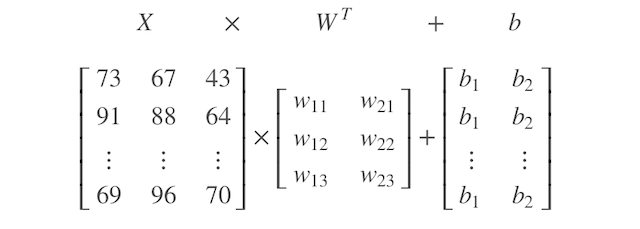


In [ ]:
import torch.nn as nn

# this will dictate the rows of the theta matrix
inputSize = 3*32*32

# this will dictate the columns of the theta matrix
numClasses = 10

# create our linear regression model (nn.Linear creates bias terms for us)
model = nn.Linear(inputSize, numClasses)

This is a lot like linear regression, just with a lot more parameters. Let's see exactly how many parameters we have.

In [ ]:
print('dimensions of weight matrix: ' + str(model.weight.shape))
print(model.weight)

dimensions of weight matrix: torch.Size([10, 3072])
Parameter containing:
tensor([[-0.0105,  0.0064, -0.0055,  ...,  0.0055, -0.0057,  0.0074],
        [ 0.0096, -0.0057,  0.0021,  ..., -0.0118, -0.0045, -0.0153],
        [-0.0024, -0.0109,  0.0070,  ...,  0.0004,  0.0009,  0.0037],
        ...,
        [ 0.0031,  0.0158, -0.0113,  ...,  0.0011, -0.0153, -0.0152],
        [-0.0158,  0.0177, -0.0020,  ..., -0.0129, -0.0108, -0.0060],
        [-0.0014, -0.0141, -0.0122,  ...,  0.0174, -0.0094,  0.0167]],
       requires_grad=True)


In [ ]:
print('dimensions of bias matrix: ' + str(model.bias.shape))
print(model.bias)

dimensions of bias matrix: torch.Size([10])
Parameter containing:
tensor([-0.0054,  0.0002,  0.0160, -0.0113, -0.0071,  0.0009,  0.0063, -0.0164,
        -0.0119,  0.0070], requires_grad=True)


Now let's take the first 100 images from the dataset, and pass it into our model.

In [ ]:
for images, labels in trainLoader:
   print(labels)
   #print(images.shape)
   #outputs = model(images)
   #break

tensor([4, 4, 7, 2, 3, 6, 5, 4, 7, 6, 5, 6, 4, 0, 2, 3, 9, 7, 1, 4, 6, 5, 1, 2,
        5, 2, 3, 1, 8, 7, 7, 1, 8, 2, 6, 6, 4, 6, 1, 2, 3, 1, 9, 6, 3, 7, 0, 8,
        3, 0, 0, 2, 1, 0, 0, 4, 7, 5, 6, 8, 4, 8, 4, 8, 0, 9, 8, 4, 8, 1, 6, 7,
        0, 3, 5, 5, 5, 9, 2, 4, 1, 2, 9, 3, 3, 9, 1, 1, 5, 5, 4, 4, 8, 1, 7, 8,
        9, 5, 9, 4])
tensor([5, 7, 4, 9, 8, 6, 0, 3, 4, 8, 1, 4, 6, 0, 1, 1, 1, 2, 1, 3, 0, 3, 1, 2,
        4, 9, 5, 2, 7, 1, 3, 5, 0, 4, 4, 7, 2, 3, 7, 3, 2, 4, 2, 9, 5, 4, 9, 6,
        7, 6, 3, 5, 2, 2, 2, 6, 6, 9, 1, 9, 8, 2, 0, 7, 2, 0, 2, 5, 0, 6, 6, 1,
        0, 9, 0, 9, 9, 2, 7, 6, 7, 4, 0, 9, 1, 9, 6, 6, 7, 6, 4, 8, 0, 6, 9, 3,
        1, 5, 7, 4])
tensor([9, 8, 7, 3, 3, 3, 8, 0, 8, 7, 7, 8, 6, 8, 4, 2, 3, 2, 4, 5, 9, 6, 4, 6,
        7, 0, 4, 1, 1, 6, 7, 5, 3, 0, 5, 8, 6, 9, 4, 4, 9, 0, 4, 5, 2, 6, 7, 1,
        4, 7, 2, 2, 9, 6, 2, 9, 4, 0, 4, 1, 8, 5, 1, 6, 0, 7, 2, 5, 4, 8, 5, 2,
        9, 9, 5, 6, 8, 4, 5, 1, 3, 1, 2, 5, 1, 0, 5, 5, 5, 7, 0, 2, 7, 0, 1, 7

**This implementation doesn't work** because nn.Linear expects a vector as input for values for features - a 3072 long vector for each image, which means eacg rows containins 3072 values, The Columns are  the nn.Module class itself to deal with vectors in size. We are currently giving columns of 100x3x32x32, but need matrices of 100 x (3x32x32)

This means we will have to edit the functionality of nn.Linear itself, by using classes. This is basically extening nn.Module in PyTorch.

Practically, what we're trying to do is create a class that contains a function similar to linear, but instead of linear, it reshapes the matrix to be (-1, 3072) which adapts to any training batch, then inserts it into linear.

In [ ]:
class CIFAR10(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(inputSize, numClasses)

    def forward(self, xb):
        xb = xb.reshape(-1, 3072)
        out = self.linear(xb)
        return out

model = CIFAR10()

Now we can get some predictions. This WORKS now, since we are using our modified model, which, for example, with batch size of ONE:
1.   Trainloader finds the RGB matrix associated with the randomly picked index from SubsetRandomSampler.
2.   This single image, which is matrix of size 3x32x32, is put into our modified model function, which was modified from nn.linear.
3. Our modified function turns this four dimensional matrix (batch x 3 x 32 x 32) into a two dimensional matrix (batch x 3072).
4. Our modified CIFAR10() function returns what would be the output of nn.linear, if we had manually changed batch x 3 x 32 x 32 into a 2D matrix.





We can still access the paramaters and bias terms of the linear function nested inside our new model function.

In [ ]:
print(model.linear.weight.shape)
print(model.linear.bias.shape)

torch.Size([10, 3072])
torch.Size([10])


Now, we see, after all of this, we get, for the first two images (outputs[:2]) a vector of 10 describing the possibility of each class.

**How did we get here**

1.   Import dataset and transform images to RGB matrices of 3x32x32.
2.   Split dataset randomly into 50000 training examples and 10000 validation
3.   Via SubsetRandomSampler, the dataset is shuffled once again into an iterative object.
4.   Via DataLoader, the randomly shuffled indexes paired with corresponding image matrices, in preset batches decided by batchSize.
5. Modify the nn.linear function by editing the class nn.model, and making it so that nn.linear automatically flattens a matrix before entering it in nn.linear
6. Inputting the number of classes (X's rows) and number of features (X's columns) into nn.linear gives us a model, and empty set of thetas to multiply something by.
7. By iterating through our trainLoader, which contains both the image matrix and the labels, we can input the image matrices through our model to get our outputs.

the dimensions, with a batch of 100, of each of the matrices is:
X = (100 x 32x32x3) = (100 x 3072)
theta = (10 x 3072)

if we transpose theta, we get (100 x 3072) (3072 x 10), which we can multiply, giving us a total output vector of (100 x 10), which is a result vector for each of our training examples in that batch.





In [ ]:
for images, labels in trainLoader:
  outputs = model(images)
  break

print('outputs.shape :', outputs.shape)
print('sample outputs :\n', outputs[:2]) # print 2 out of the 100 rows of the total output vector

outputs.shape : torch.Size([100, 10])
sample outputs :
 tensor([[ 0.1867,  0.2954,  0.2088,  0.2075,  0.1881, -0.2110,  0.1993, -0.0620,
         -0.1926, -0.2039],
        [ 0.3933,  0.1912,  0.0773,  0.2371,  0.2526, -0.0769,  0.5262, -0.1516,
         -0.3123, -0.3357]], grad_fn=<SliceBackward0>)


**softmax function** now, we need some way to convert the logits in the vectors above to concrete percentages. This is through the softmax function: good explanation here: https://www.youtube.com/watch?v=8ps_JEW42xs&ab_channel=ritvikmath

In [ ]:
import torch.nn.functional as F

We need to specify what dimension we want softmax to be applied upon.

In [ ]:
# apply the softmax for each output row in our 100 x 10 output (with batch size 100)
probs = F.softmax(outputs, dim=1)

# look at some sample probabilities
print("sample probabilities:\n", probs[:2].data)
# add up the probabilities of each row for a sanity check that they equal 1 now
print(sum(list(probs[0])))

sample probabilities:
 tensor([[0.1113, 0.1241, 0.1138, 0.1136, 0.1115, 0.0748, 0.1127, 0.0868, 0.0762,
         0.0753],
        [0.1317, 0.1076, 0.0960, 0.1127, 0.1144, 0.0823, 0.1504, 0.0764, 0.0650,
         0.0635]])
tensor(1., grad_fn=<AddBackward0>)


Now, we can find the maximum value in each row to find the largest percentage, and thus, the prediction of the algorithm.

We can see that when our paramaters are randomized, our algorithm is partial to guessing 6 (frog). Let's compare this predictions vector with our actual labels to calculate accuracy.

In [ ]:
maxProbs, preds = torch.max(probs, dim=1) #torch.max returns the max value itself (maxProbs) as well as the index of the prediction (preds)
print(preds)
print(maxProbs)

tensor([1, 6, 2, 1, 1, 6, 1, 6, 6, 6, 2, 4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6,
        1, 6, 6, 0, 6, 1, 2, 1, 6, 2, 2, 6, 6, 4, 2, 2, 3, 1, 6, 6, 6, 2, 4, 4,
        6, 1, 6, 1, 6, 6, 1, 6, 6, 6, 6, 3, 4, 6, 6, 6, 6, 4, 1, 6, 2, 1, 6, 4,
        6, 6, 6, 6, 4, 1, 2, 1, 4, 3, 6, 0, 1, 6, 6, 6, 1, 6, 1, 6, 4, 1, 4, 6,
        1, 1, 6, 0])
tensor([0.1241, 0.1504, 0.1349, 0.1163, 0.1377, 0.1374, 0.1773, 0.1412, 0.1389,
        0.1400, 0.1377, 0.1469, 0.1551, 0.1776, 0.2154, 0.1797, 0.1417, 0.1513,
        0.1634, 0.1275, 0.1482, 0.1478, 0.1637, 0.1584, 0.1666, 0.1681, 0.1655,
        0.1348, 0.1551, 0.1424, 0.1338, 0.1751, 0.1572, 0.1554, 0.1199, 0.1619,
        0.1359, 0.1172, 0.1361, 0.1483, 0.1445, 0.1211, 0.1608, 0.1577, 0.1362,
        0.1331, 0.1463, 0.1264, 0.1679, 0.1230, 0.1679, 0.1559, 0.1396, 0.1295,
        0.1344, 0.1349, 0.1505, 0.1387, 0.1567, 0.1324, 0.1399, 0.1372, 0.1309,
        0.1530, 0.1682, 0.1797, 0.1487, 0.1428, 0.1315, 0.1407, 0.1368, 0.1338,
        0.1480, 0.1

In [ ]:
#jovian.commit(project="CIFAR-10 Logistic Regression Predictor")

# Evaluation and Cost function


---

A natural way to evaluate the algorithm is to see the accuracy score w.r.t the labels of the training set.

In [ ]:
labels==preds

tensor([False, False, False, False, False,  True, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False,  True, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
         True, False, False, False, False,  True, False,  True, False, False,
        False, False, False, False, False, False, False, False, False,  True,
        False, False, False, False, False, False, False, False, False,  True])

Create a function that adds up all the correct predictions and divides it by the total length of the labels.

In [ ]:
def accuracy(preds, labels):
  return torch.sum(labels==preds).item() / len(labels)

In [ ]:
accuracy(preds, labels)

0.08

But this is not a good cost function at all.

*   The '==' operator as well as torch.max are both not differentiable functions (how the hell would you find the derivative of ==?).
*   The difference is black and white. Even if your percentages are getting more accurate, your model will not show this (it only shows straight predictions and not the percentages themselves).

Instead, we use cross entropy, or 'log loss', to calculate the cost function.

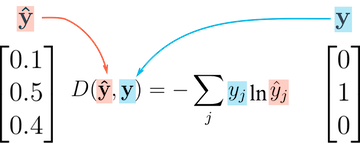



Basically, you're comparing your vector of probabilities to the result vector, which would look something like [0, 0, 0, 0, 0, 0, 0, 1, 0, 0,]. Then, you take the negative log of the probability predicted for the right answer. E.g, if you had

[0, 0, 0, 1, 0] and
[0.51, 0.22, 0.001, 0.34, 0.02]

You would be taking the negative log of 0.34. The closer 0.34 gets to 1, the smaller that value becomes. Looking at the graph of negative log, this makes sense.

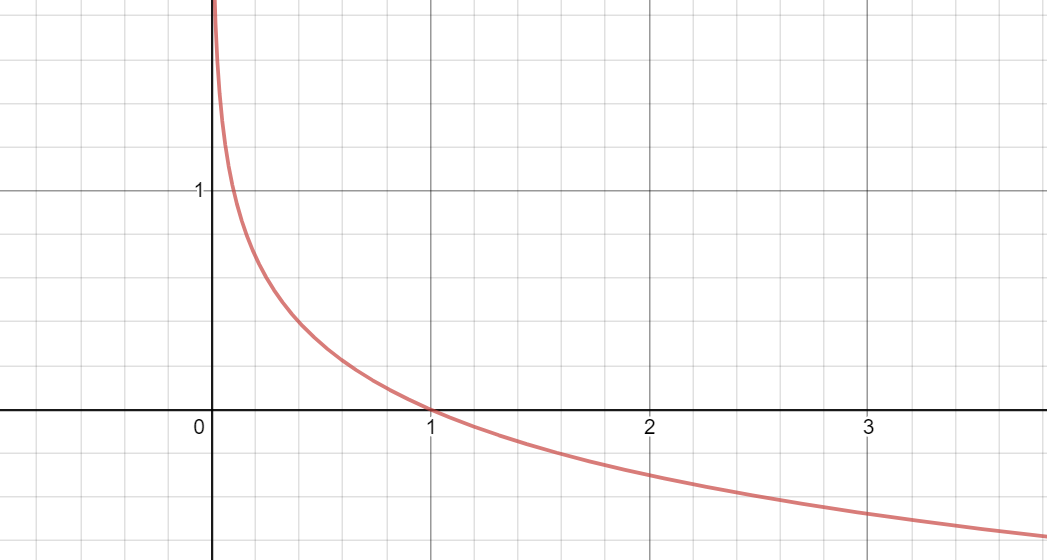

Cross entropy is a differentiable, continuous function that can be minimized and tracked well. The cross_entropy function in pytorch also executes the softmax function as well.

In [ ]:
lossFn = F.cross_entropy

In [ ]:
# loss for current batch of data
# remember that outputs are our thetas gathered from the model
# labels is correct answers from dataLoader
loss = lossFn(outputs, labels)
print(loss)

tensor(2.3647, grad_fn=<NllLossBackward0>)


Since the cross entropy is the negative logarithm of the predicted probability of the correct label averaged over all training samples, one way to interpret the resulting number e.g. 2.23 is look at e^-2.23 which is around 0.1 as the predicted probability of the correct label, on average. Lower the loss, better the model.

# Optimization using SDG


---
We will once again use stochastic gradient descent to update our algorithm. Choose a slightly larger learningRate, a hyperparameter, than last time.


In [ ]:
learningRate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

# Training the model


---


We train the model quite similarly to our linear regression example. We have now evaluated and created the:


*   Data loaders
*   Model
*   Loss function
*   Optimizer

We can now train the model. This model will use the training set (xb, yb) to train the parameters, and will evaluate the cost function again for the cross validation set.

Let's define a function lossBatch which calculates the loss for some given batch, and performs a gradient update step for ALL the parameters based on that batch if an optimizer is provided. Also, it computes a metric (e.g accuracy) optionally.




In [ ]:
# recall that xb is the X (a list batchSize long of 3x32x32 images) for a batch. yb is the corresponding labels for those images.

def lossBatch(model, lossFn, xb, yb, opt=None, metric=None):
  # calculate the loss
  preds = model(xb)
  loss = lossFn(preds, yb)

  if opt is not None:
    # compute gradients
    loss.backward()
    # update parameters
    opt.step()
    # reset gradients to 0 (don't want to calculate second derivatives!)
    opt.zero_grad()

  metricResult = None
  if metric is not None:
    metricResult = metric(preds, yb)

  return loss.item(), len(xb),  metricResult

The above code defines a function, when given the
* model (linear.nn), the loss function (cross entropy)
*  xb (the images matrices for the given batch)
* yb (the corresponding labels for that batch)
* and optionally, opt (the optimization algorithm)
*  metric (some sort of metric that takes in predictions and yb and gives out some sort of evaluation metric).

Gives back
* the loss for the training set for that batch (loss.item())
* the length of the batch (xb)
* the result of the metric, if given (metricResult)


Next, let's define a function that computes and evaluates the total cost on the validation set.

In [ ]:
def evaluate(model, lossFn, validDL, metric=None):
  #with torch.no_grad (this was causing an error)

  # pass each batch of the validation set through the model to form a multidimensional list (holding loss, length and metric for each batch)
  # the reason why we made optimization optional is so we can reuse the function here
  results = [lossBatch(model, lossFn, xb, yb, metric=metric,) for xb,yb in validDL]

  # separate losses, counts and metrics
  losses, nums, metrics = zip(*results)

  # total size of the dataset (we keep track of lengths of batches since dataset might not be perfectly divisible by batch size)
  total = np.sum(nums)

  # find average total loss over all batches in validation (remember these are all vectors doing element wise operations.)
  avgLoss = np.sum(np.multiply(losses, nums))/total

  # if there is a metric passed, compute the average metric
  if metric is not None:
    # avg of metric accross batches
    avgMetric = np.sum(np.multiply(metrics, nums)) / total

  return avgLoss, total, avgMetric

Make a version of evaluate with training AND validation, so we can plot learning curves.

We also need to redefine our metric, accuracy, to operate on a batch of outputs directly as opposed to just getting predictions and labels.

Recall that outputs is the batch_size x 10 matrix (the product of the theta and X matrices) where each row is a horizontal vector of logits.

In [ ]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1) # underscore discards the max value itself, we don't care about that
  return torch.sum(preds == labels).item() / len(preds)

Accuracy takes in the outputs (batchSize x 10) and labels (1 x batchSize) of that given batch. It then gets the index of the max values for each row of outputs, which is the predicted value for each training example. Then, it sums the boolean matrix created by preds == labels, and divides it by the length of the batch, to get the accuracy of the predictions.

Let's predict the validation accuracy for our current set of thetas.




In [ ]:
E = evaluate(model, lossFn, valLoader, metric=accuracy)

print("training set loss: ", loss)
print("cross validation set loss: ", E[0])

training set loss:  tensor(2.3647, grad_fn=<NllLossBackward0>)
cross validation set loss:  2.3385784959793092


In [ ]:
def fit(epochs, model, lossFn, opt, trainDL, valDL, metric=None):
  valList = [0.10]
  for epoch in range(epochs):
    # training - perform one step gradient descent on each batch, then moves on
    for xb, yb in trainDL:
      loss,_,lossMetric = lossBatch(model, lossFn, xb, yb, opt)


    # evaluation on cross val dataset - after updating over all batches, technically one epoch
    # evaluates over all validation batches and then calculates average val loss, as well as the metric (accuracy)
    valResult = evaluate(model, lossFn, valDL, metric)
    valLoss, total, valMetric = valResult
    valList.append(valMetric)
    # print progress
    if metric is None:
      print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch + 1, epochs, valLoss))
    else:
      print('Epoch [{}/{}], Loss: {:.4f}, {}: {:.4f}'.format(epoch + 1, epochs, valLoss, metric.__name__, valMetric))

  return valList

Now, we can fit our model. (version with vals and trains)

**Recap**

1.   First, we load our CIFAR-10 dataset.
2.   Then, we upload images in batches of 100 at a time.
3.   Then, we convert our images into 3x32x32 tensors. This makes our batch matrix 100 x 3 x 32 x 32 in dimensions.
4.   Then, we pass each batch into the CIFAR10 model, which converts the tensors from 100 x 3 x 32 x 32 to 100 x 3072.
5.   Then, we multiply it by the weights matrix, which is [10 x 3072], which is transposed to be multiplied by each tensor batch
6.   This multiplication gives a 100 x 10 results matrix, with logits, and we add the bias.
7.   Then, softmax is applied on the logits to convert them into probabilities
8.   Then, cross entropy is performed on the probabilites matrix to give a continuous and differentiable cost function.
9.   Then, cross entropy from all the different batches is combined to give a total training loss.
10.  Then we calculate the partial derivatives of this cross entropy function with respect to every one of the 10x3072 weights and biases.
11.  Then, we subtract the gradient (the vector of all 10x3072 partial derivatives) from the vector of current thetas, for each batch. (so, youre subtracting from theta 100 times)
12.  We do step 11 for each number of epochs.




In [ ]:
# redefine model and optimizer
learningRate = 0.009
model = CIFAR10()
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

In [ ]:
trainList = fit(100, model, lossFn, optimizer, trainLoader, valLoader, metric=accuracy)

Epoch [1/100], Loss: 1.8874, accuracy: 0.3457
Epoch [2/100], Loss: 1.8410, accuracy: 0.3564
Epoch [3/100], Loss: 1.8149, accuracy: 0.3755
Epoch [4/100], Loss: 1.8065, accuracy: 0.3760
Epoch [5/100], Loss: 1.8191, accuracy: 0.3540
Epoch [6/100], Loss: 1.7857, accuracy: 0.3837
Epoch [7/100], Loss: 1.7746, accuracy: 0.3850
Epoch [8/100], Loss: 1.7767, accuracy: 0.3826
Epoch [9/100], Loss: 1.7635, accuracy: 0.3890
Epoch [10/100], Loss: 1.7598, accuracy: 0.3942
Epoch [11/100], Loss: 1.7552, accuracy: 0.4002
Epoch [12/100], Loss: 1.7763, accuracy: 0.3830
Epoch [13/100], Loss: 1.7597, accuracy: 0.3937
Epoch [14/100], Loss: 1.7607, accuracy: 0.3857
Epoch [15/100], Loss: 1.7492, accuracy: 0.3960
Epoch [16/100], Loss: 1.7586, accuracy: 0.3850
Epoch [17/100], Loss: 1.7377, accuracy: 0.3983
Epoch [18/100], Loss: 1.7448, accuracy: 0.3956
Epoch [19/100], Loss: 1.7507, accuracy: 0.3885
Epoch [20/100], Loss: 1.7315, accuracy: 0.4037
Epoch [21/100], Loss: 1.7337, accuracy: 0.4023
Epoch [22/100], Loss: 

Now, let's look at the accuracies on the training, validation, and test sets.

In [ ]:
test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=torchvision.transforms.ToTensor())

Files already downloaded and verified


In [ ]:
testLoader = DataLoader(test, batchSize)

In [ ]:
avgLoss, total, avgMetric = evaluate(model, F.cross_entropy, testLoader, metric=accuracy)
print("test set accuracy: \n", avgMetric)
avgLoss, total, avgMetric = evaluate(model, F.cross_entropy, valLoader, metric=accuracy)
print("cross validation set accuracy: \n",avgMetric)
avgLoss, total, avgMetric = evaluate(model, F.cross_entropy, trainLoader, metric=accuracy)
print("training set accuracy: \n",avgMetric)

test set accuracy: 
 0.4005
cross validation set accuracy: 
 0.4053
training set accuracy: 
 0.4398
